# Loading Data in MySql Database #

In [1]:
import pandas as pd
import mysql.connector
import os

# List of CSV files and their corresponding table names
csv_files = [
    ('customers.csv', 'customers'),
    ('orders.csv', 'orders'),
    ('sellers.csv', 'sellers'),
    ('products.csv', 'products'),
    ('payments.csv', 'payments'),
    ('geolocation.csv','geolocation'),
    ('order_items.csv','order_items')
]

# Connect to the MySQL database (use your information)
conn = mysql.connector.connect(
    host='localhost',
    user='root',
    password='root',
    database='ecommerce'
)
cursor = conn.cursor()

# Folder containing the CSV files(use your file location)
folder_path = 'E:/Keggle data/E-commerce data'

def get_sql_type(dtype):
    if pd.api.types.is_integer_dtype(dtype):
        return 'INT'
    elif pd.api.types.is_float_dtype(dtype):
        return 'FLOAT'
    elif pd.api.types.is_bool_dtype(dtype):
        return 'BOOLEAN'
    elif pd.api.types.is_datetime64_any_dtype(dtype):
        return 'DATETIME'
    else:
        return 'TEXT'

for csv_file, table_name in csv_files:
    file_path = os.path.join(folder_path, csv_file)

    # Read the CSV file into a pandas DataFrame
    df = pd.read_csv(file_path)

    # Replace NaN with None to handle SQL NULL
    df = df.where(pd.notnull(df), None)

    # Debugging: Check for NaN values
    print(f"Processing {csv_file}")
    print(f"NaN values before replacement:\n{df.isnull().sum()}\n")

    # Clean column names
    df.columns = [col.replace(' ', '_').replace('-', '_').replace('.', '_') for col in df.columns]

    # Generate the CREATE TABLE statement with appropriate data types
    columns = ', '.join([f'`{col}` {get_sql_type(df[col].dtype)}' for col in df.columns])
    create_table_query = f'CREATE TABLE IF NOT EXISTS `{table_name}` ({columns})'
    cursor.execute(create_table_query)

    # Insert DataFrame data into the MySQL table
    for _, row in df.iterrows():
        # Convert row to tuple and handle NaN/None explicitly
        values = tuple(None if pd.isna(x) else x for x in row)
        sql = f"INSERT INTO `{table_name}` ({', '.join(['`' + col + '`' for col in df.columns])}) VALUES ({', '.join(['%s'] * len(row))})"
        cursor.execute(sql, values)

    # Commit the transaction for the current CSV file
    conn.commit()

# Close the connection
conn.close()

Processing customers.csv
NaN values before replacement:
customer_id                 0
customer_unique_id          0
customer_zip_code_prefix    0
customer_city               0
customer_state              0
dtype: int64

Processing orders.csv
NaN values before replacement:
order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                 160
order_delivered_carrier_date     1783
order_delivered_customer_date    2965
order_estimated_delivery_date       0
dtype: int64

Processing sellers.csv
NaN values before replacement:
seller_id                 0
seller_zip_code_prefix    0
seller_city               0
seller_state              0
dtype: int64

Processing products.csv
NaN values before replacement:
product_id                      0
product category              610
product_name_length           610
product_description_length    610
product_photos_qty            610
prod

# Importing necessary library and connecting MySql server

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import mysql.connector
import numpy as np


db = mysql.connector.connect(host = "localhost",
                            username = "root",
                            password = "root",
                            database = "ecommerce")

cur = db.cursor()

# List all unique cities where customers are located.

In [3]:
query = """ select distinct customer_city from customers """

cur.execute(query)

data = cur.fetchall()

df = pd.DataFrame(data)
df.head()

,0
0,franca
1,sao bernardo do campo
2,sao paulo
3,mogi das cruzes
4,campinas


# Count the number of orders placed in 2017.

In [4]:
query = """ select count(order_id) from orders where year(order_purchase_timestamp) = 2017 """

cur.execute(query)

data = cur.fetchall()

print("total orders placed in 2017 are:", data[0][0])

total orders placed in 2017 are: 45101


# Find the total sales per category.

In [5]:
query = """ SELECT 
    UPPER(products.product_category) AS category,
    ROUND(SUM(payments.payment_value)) AS  sales
FROM
    products
        JOIN
    order_items ON products.product_id = order_items.product_id
        JOIN
    payments ON payments.order_id = order_items.order_id
GROUP BY category
ORDER BY sales DESC
"""

cur.execute(query)

data = cur.fetchall()

df = pd.DataFrame(data, columns = ["Category", "Sales"])
df

,Category,Sales
0,BED TABLE BATH,1712554.0
1,HEALTH BEAUTY,1657373.0
2,COMPUTER ACCESSORIES,1585330.0
3,FURNITURE DECORATION,1430176.0
4,WATCHES PRESENT,1429217.0
...,...,...
69,PC GAMER,2174.0
70,HOUSE COMFORT 2,1711.0
71,CDS MUSIC DVDS,1199.0
72,FASHION CHILDREN'S CLOTHING,786.0


# Calculate the percentage of orders that were paid in installments.

In [6]:
query = """ SELECT 
    CONCAT(ROUND(
        100.0 * COUNT(DISTINCT CASE
            WHEN payment_installments > 1 THEN order_id
        END) / COUNT(DISTINCT order_id), 2), '%')
FROM
    payments;

"""

cur.execute(query)

data = cur.fetchall()

print("the percentage of orders that were paid in installments is:", data[0][0])

the percentage of orders that were paid in installments is: 51.46%


# Count the number of customers from each state.

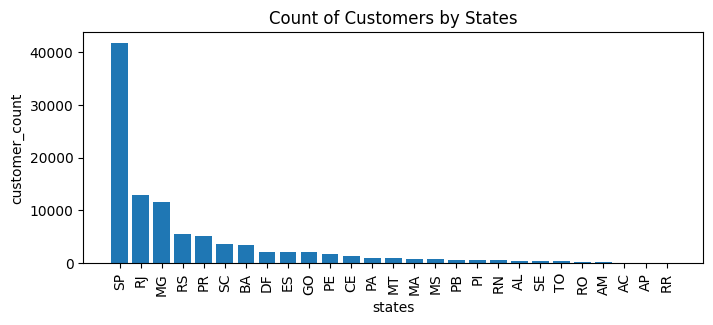

In [7]:
query = """ SELECT 
    customer_state, COUNT(customer_id)
FROM
    customers
GROUP BY customer_state
"""

cur.execute(query)

data = cur.fetchall()
df = pd.DataFrame(data, columns = ["state", "customer_count" ])
df = df.sort_values(by = "customer_count", ascending= False)

plt.figure(figsize = (8,3))
plt.bar(df["state"], df["customer_count"])
plt.xticks(rotation = 90)
plt.xlabel("states")
plt.ylabel("customer_count")
plt.title("Count of Customers by States")

# Display the plot; this is essential when running the script outside Jupyter (e.g., .py files or functions).
# While optional in notebooks, it's a good practice to include it for clarity and portability.
plt.show()


# Calculate the number of orders per month in 2018.

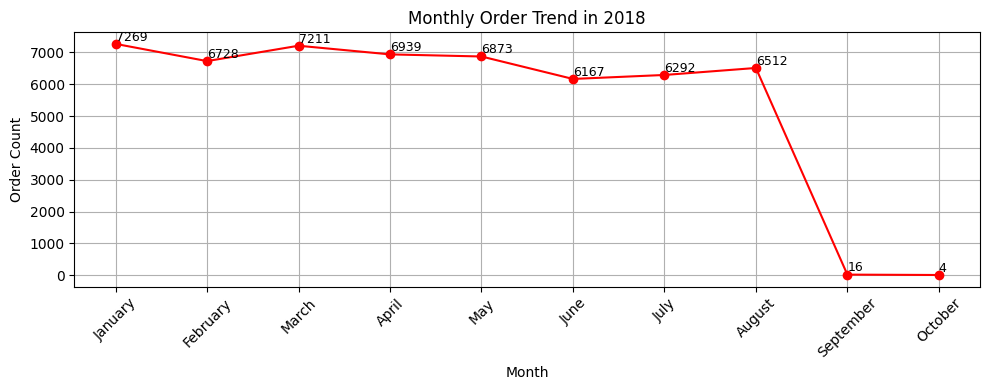

In [8]:
query = """
SELECT 
    MONTHNAME(order_purchase_timestamp) AS months,
    COUNT(order_id) AS order_count
FROM 
    orders 
WHERE 
    YEAR(order_purchase_timestamp) = 2018
GROUP BY 
    months
"""

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns=["months", "order_count"])

# Order months correctly
month_order = ["January", "February", "March", "April", "May", "June", 
               "July", "August", "September", "October", "November", "December"]

df["months"] = pd.Categorical(df["months"], categories=month_order, ordered=True)
df = df.sort_values("months")

# Plot as line chart
plt.figure(figsize=(10, 4))
plt.plot(df["months"], df["order_count"], marker='o', linestyle='-', color='red')

# ✅ Add data labels to each point
for x, y in zip(df["months"], df["order_count"]):
    plt.text(x=x, y=y + 5, s=str(y), va='bottom', fontsize=9, color='black')

plt.xticks(rotation=45)
plt.xlabel("Month")
plt.ylabel("Order Count")
plt.title("Monthly Order Trend in 2018")
plt.grid(True)
plt.tight_layout()
# Display the plot; this is essential when running the script outside Jupyter (e.g., .py files or functions).
# While optional in notebooks, it's a good practice to include it for clarity and portability.
plt.show()


# Find the average number of products per order, grouped by customer city.

In [9]:
query = """WITH count_per_order AS (
    SELECT 
        orders.order_id, 
        orders.customer_id, 
        COUNT(order_items.order_id) AS oc
    FROM orders 
    JOIN order_items ON orders.order_id = order_items.order_id
    GROUP BY orders.order_id, orders.customer_id

)

SELECT 
    c.customer_city, 
    ROUND(AVG(cpo.oc), 2) AS average_orders
FROM customers c
JOIN count_per_order cpo ON c.customer_id = cpo.customer_id
GROUP BY c.customer_city
ORDER BY average_orders DESC;
"""

cur.execute(query)

data = cur.fetchall()
df = pd.DataFrame(data,columns = ["customer city", "average products/order"])
df.head(10)


,customer city,average products/order
0,padre carvalho,7.00
1,celso ramos,6.50
2,datas,6.00
3,candido godoi,6.00
4,matias olimpio,5.00
5,cidelandia,4.00
6,picarra,4.00
7,morro de sao paulo,4.00
8,teixeira soares,4.00
9,curralinho,4.00


# Calculate the percentage of total revenue contributed by each product category.

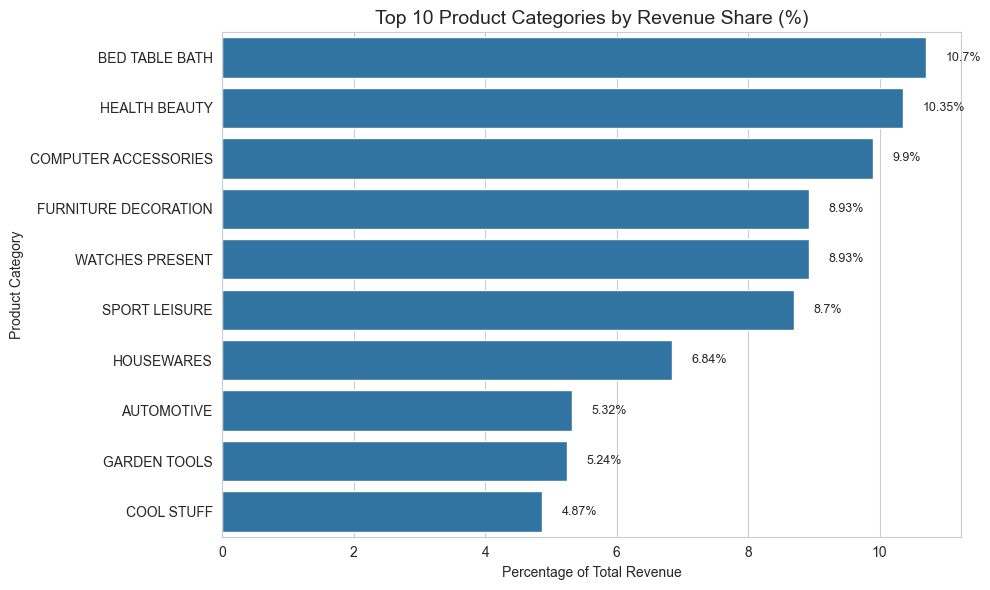

In [10]:
query = """
SELECT 
    UPPER(products.product_category) category,
    ROUND((SUM(payments.payment_value) / (SELECT 
                    SUM(payment_value)
                FROM
                    payments)) * 100,
            2) sales_percentage
FROM
    products
        JOIN
    order_items ON products.product_id = order_items.product_id
        JOIN
    payments ON payments.order_id = order_items.order_id
GROUP BY category
ORDER BY sales_percentage DESC
"""


cur.execute(query)

data = cur.fetchall()
df = pd.DataFrame(data, columns=["Category", "Percentage Distribution"])

# ✅ Keep only the top 10 categories
df_top10 = df.head(10)

# Plotting
plt.figure(figsize=(10, 6))
sns.set_style("whitegrid")

ax = sns.barplot(
    x="Percentage Distribution", 
    y="Category", 
    data=df_top10
)

# Add data labels
for i, value in enumerate(df_top10["Percentage Distribution"]):
    plt.text(value + 0.3, i, f"{value}%", va='center', fontsize=9)

# Titles and labels
plt.title("Top 10 Product Categories by Revenue Share (%)", fontsize=14)
plt.xlabel("Percentage of Total Revenue")
plt.ylabel("Product Category")
plt.tight_layout()
plt.show()


# Identify the correlation between product price and the number of times a product has been purchased.

In [15]:
query = """SELECT 
    product_id,
    COUNT(*) AS times_ordered,
    round(AVG(price),2) AS avg_price  -- or MIN/AVG if price varies per order
FROM order_items
GROUP BY product_id
ORDER BY times_ordered DESC;"""

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data,columns = ["product_ID", "times_ordered","avg_price"])

arr1 = df["times_ordered"]
arr2 = df["avg_price"]

correlation = np.corrcoef(arr1, arr2)[0, 1]
print(f"📈 Pearson correlation coefficient: {correlation:.4f}")

📈 Pearson correlation coefficient: -0.0321


# Calculate the total revenue generated by each seller, and rank them by revenue.

In [19]:
query = """WITH seller_revenue AS (
    SELECT 
        oi.seller_id,
        SUM(p.payment_value) AS total_revenue
    FROM order_items AS oi
	JOIN payments AS p ON p.order_id = oi.order_id
    GROUP BY oi.seller_id
)

SELECT 
    seller_id,
    total_revenue,
    DENSE_RANK() OVER (ORDER BY total_revenue DESC) AS revenue_rank
FROM seller_revenue
ORDER BY revenue_rank;"""

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data,columns = ["seller_id", "total_revenue","revenue_rank"])
df.head(10)

,seller_id,total_revenue,revenue_rank
0,7c67e1448b00f6e969d365cea6b010ab,507166.907302,1
1,1025f0e2d44d7041d6cf58b6550e0bfa,308222.039840,2
2,4a3ca9315b744ce9f8e9374361493884,301245.269765,3
3,1f50f920176fa81dab994f9023523100,290253.420128,4
4,53243585a1d6dc2643021fd1853d8905,284903.080498,5
5,da8622b14eb17ae2831f4ac5b9dab84a,272219.319315,6
6,4869f7a5dfa277a7dca6462dcf3b52b2,264166.120939,7
7,955fee9216a65b617aa5c0531780ce60,236322.300502,8
8,fa1c13f2614d7b5c4749cbc52fecda94,206513.229870,9
9,7e93a43ef30c4f03f38b393420bc753a,185134.209706,10


# Calculate the moving average of order values for each customer over their order history.

In [29]:
query = """SELECT 
    c.customer_unique_id, 
    o.order_purchase_timestamp,
    p.payment_value,
    AVG(p.payment_value) OVER (
         PARTITION BY c.customer_unique_id
        ORDER BY o.order_purchase_timestamp
        ROWS BETWEEN 2 PRECEDING AND CURRENT ROW
    ) AS mov_avg
FROM orders AS o
JOIN payments AS p ON p.order_id = o.order_id
join customers as c on c.customer_id = o.customer_id
order by  c.customer_unique_id , o.order_purchase_timestamp"""

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data,columns =["customer_unique_id","order_purchase_timestamp","payment_value","mov_avg"])
df.head(10)

,customer_unique_id,order_purchase_timestamp,payment_value,mov_avg
0,0000366f3b9a7992bf8c76cfdf3221e2,2018-05-10 10:56:27,141.90,141.899994
1,0000b849f77a49e4a4ce2b2a4ca5be3f,2018-05-07 11:11:27,27.19,27.190001
2,0000f46a3911fa3c0805444483337064,2017-03-10 21:05:03,86.22,86.220001
3,0000f6ccb0745a6a4b88665a16c9f078,2017-10-12 20:29:41,43.62,43.619999
4,0004aac84e0df4da2b147fca70cf8255,2017-11-14 19:45:42,196.89,196.889999
5,0004bd2a26a76fe21f786e4fbd80607f,2018-04-05 19:33:16,166.98,166.979996
6,00050ab1314c0e55a6ca13cf7181fecf,2018-04-20 12:57:23,35.38,35.380001
7,00053a61a98854899e70ed204dd4bafe,2018-02-28 11:15:41,419.18,419.179993
8,0005e1862207bf6ccc02e4228effd9a0,2017-03-04 23:32:12,150.12,150.119995
9,0005ef4cd20d2893f0d9fbd94d3c0d97,2018-03-12 15:22:12,129.76,129.759995


# Calculate the cumulative sales per month for each year.

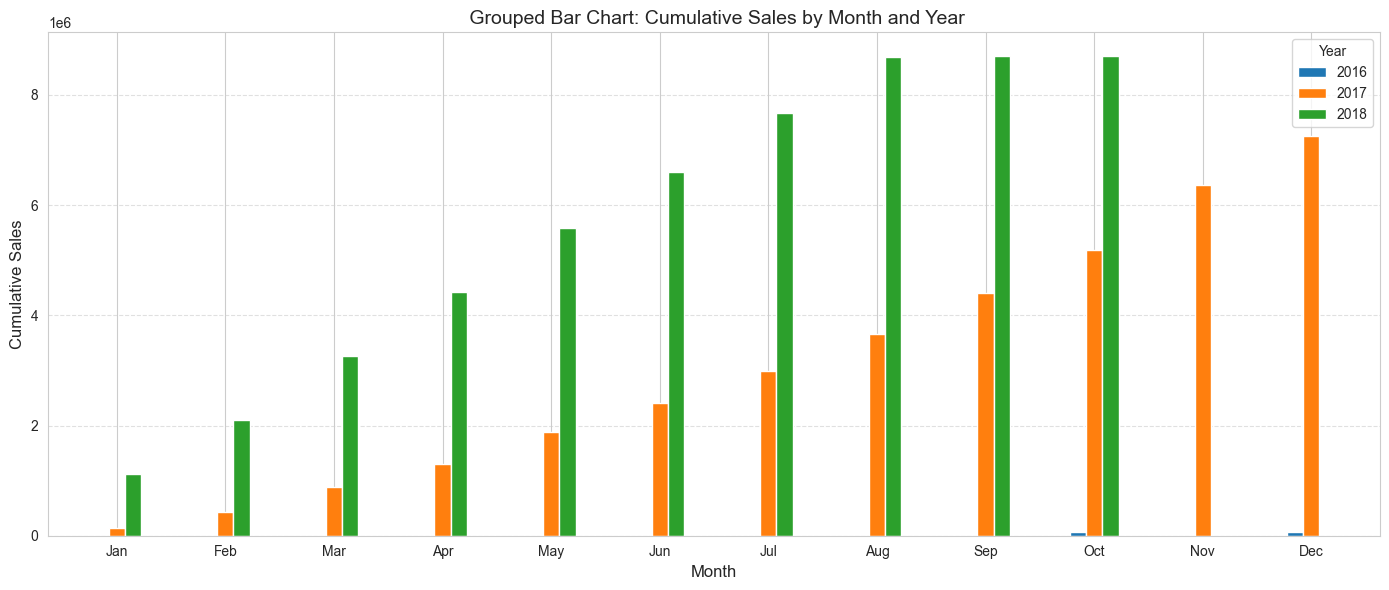

In [39]:
query = """SELECT
    YEAR(o.order_purchase_timestamp) AS year,
    MONTH(o.order_purchase_timestamp) AS month,
    SUM(p.payment_value) AS monthly_sales,
    ROUND(SUM(SUM(p.payment_value)) OVER (
        PARTITION BY YEAR(o.order_purchase_timestamp)
        ORDER BY MONTH(o.order_purchase_timestamp)
    ),2) AS cumulative_sales
FROM orders AS o
JOIN payments AS p ON o.order_id = p.order_id
GROUP BY
    YEAR(o.order_purchase_timestamp),
    MONTH(o.order_purchase_timestamp)
ORDER BY
    YEAR(o.order_purchase_timestamp),
    MONTH(o.order_purchase_timestamp);"""

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data,columns = ['year', 'month', 'monthly_sales', 'cumulative_sales'])



# Pivot data: each row = month, columns = years, values = cumulative_sales
pivot_df = df.pivot(index='month', columns='year', values='cumulative_sales')

# Setup the bar positions
months = pivot_df.index
years = pivot_df.columns.tolist()
bar_width = 0.15  # Width of each bar
x = np.arange(len(months))  # Base x-axis positions

# Plot
plt.figure(figsize=(14, 6))

for i, year in enumerate(years):
    plt.bar(x + i * bar_width, pivot_df[year], width=bar_width, label=str(year))

# Customizing x-axis
plt.xlabel('Month', fontsize=12)
plt.ylabel('Cumulative Sales', fontsize=12)
plt.title(' Grouped Bar Chart: Cumulative Sales by Month and Year', fontsize=14)
plt.xticks(ticks=x + bar_width * (len(years)-1) / 2,
           labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
                   'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])

plt.legend(title='Year')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


# Calculate the year-over-year growth rate of total sales.

In [30]:
query ="""WITH yearly_sales AS (
    SELECT 
        YEAR(o.order_purchase_timestamp) AS year,
        SUM(p.payment_value) AS total_sales
    FROM orders AS o
    JOIN payments AS p ON o.order_id = p.order_id
    GROUP BY YEAR(o.order_purchase_timestamp)
)

SELECT 
    year,
    total_sales,
    LAG(total_sales) OVER (ORDER BY year) AS previous_year_sales,
    ROUND(
        (total_sales - LAG(total_sales) OVER (ORDER BY year)) 
        / LAG(total_sales) OVER (ORDER BY year) * 100, 2
    ) AS yoy_growth_percentage
FROM yearly_sales;"""

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data,columns = ["year", "total_sales","previous_year_sales","yoy_growth_percentage"])
df['yoy_growth_percentage'] = df['yoy_growth_percentage'].apply(lambda x: f"{x:.2f}%" if pd.notnull(x) else None)
df

,year,total_sales,previous_year_sales,yoy_growth_percentage
0,2016,5.936234e+04,NaN,None
1,2017,7.249747e+06,5.936234e+04,12112.70%
2,2018,8.699763e+06,7.249747e+06,20.00%


# Calculate the retention rate of customers, defined as the percentage of customers who make another purchase within 6 months of their first purchase.

In [33]:
query ="""WITH first_purchase AS (
    SELECT
        c.customer_unique_id,
        MIN(order_purchase_timestamp) AS first_order_date
    FROM orders as o
    join customers as c on o.customer_id=c.customer_id
    GROUP BY customer_unique_id
),

repeat_purchase AS (
    SELECT DISTINCT
        c.customer_unique_id
    FROM orders o
    join customers as c on o.customer_id=c.customer_id 
    JOIN first_purchase f
        ON c.customer_unique_id = f.customer_unique_id
    WHERE o.order_purchase_timestamp > f.first_order_date
      AND o.order_purchase_timestamp <= DATE_ADD(f.first_order_date, INTERVAL 6 MONTH)
)

SELECT
    ROUND(
        (SELECT COUNT(*) FROM repeat_purchase) * 100.0
        / (SELECT COUNT(*) FROM first_purchase),
    2) AS retention_rate_percentage;
"""

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data,columns = ["retention_rate_percentage"])
df['retention_rate_percentage'] = df['retention_rate_percentage'].apply(lambda x: f"{x:.2f}%" if pd.notnull(x) else None)
df

,retention_rate_percentage
0,2.32%


# Identify the top 3 customers who spent the most money in each year.

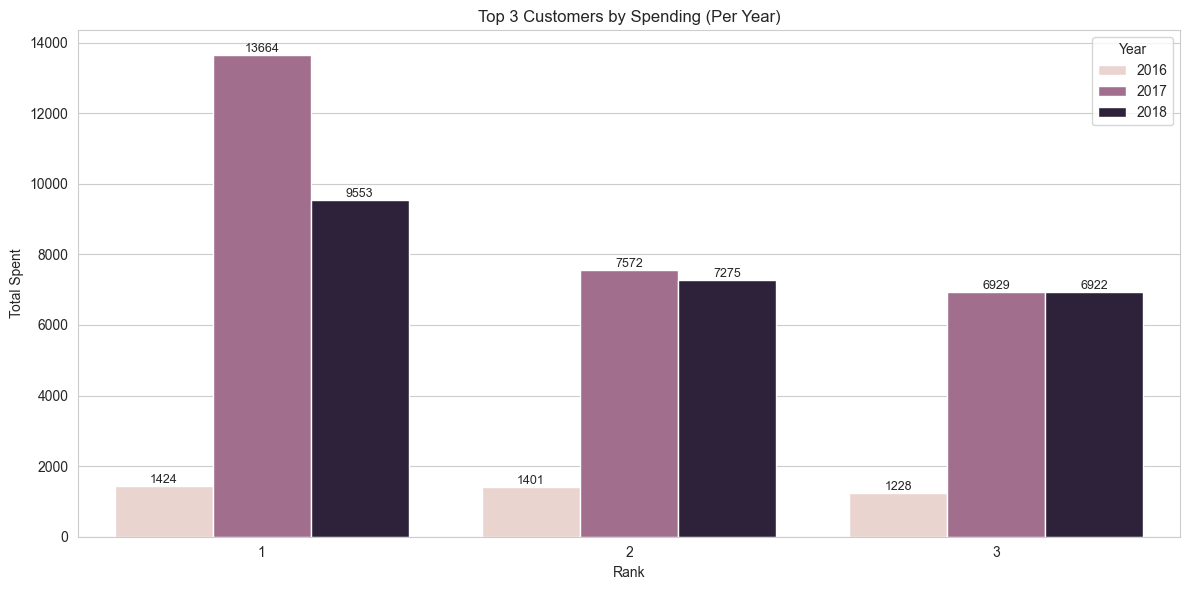

In [37]:
query ="""WITH yearly_customer_spending AS (
    SELECT
        YEAR(o.order_purchase_timestamp) AS year,
        c.customer_unique_id,
        SUM(p.payment_value) AS total_spent
    FROM orders o
    JOIN payments p ON o.order_id = p.order_id
    JOIN customers c ON o.customer_id = c.customer_id
    GROUP BY YEAR(o.order_purchase_timestamp), c.customer_unique_id
),

ranked_customers AS (
    SELECT
        year,
        customer_unique_id,
        total_spent,
        DENSE_RANK() OVER (PARTITION BY year ORDER BY total_spent DESC) AS rank_
    FROM yearly_customer_spending
)

SELECT
    year,
    customer_unique_id,
    rank_ ,
    total_spent
FROM ranked_customers
WHERE rank_ <= 3
ORDER BY year, rank_, total_spent DESC;"""

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data,columns = ["year","customer_unique_id","rank","total_spent"])



plt.figure(figsize=(12, 6))
ax = sns.barplot(data=df, x='rank', y='total_spent', hue='year')


for container in ax.containers:
    ax.bar_label(container, fmt='%.0f', label_type='edge', fontsize=9)

plt.title("Top 3 Customers by Spending (Per Year)")
plt.xlabel("Rank")
plt.ylabel("Total Spent")
plt.legend(title="Year")
plt.tight_layout()
plt.show()
